In [ ]:
import torch
import Airfoil_DDPM_tools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [112]:
# 保存到文件
save_path = os.path.join("../data","train_data_pointcloud.npz")
loaded_data = np.load(save_path)
loaded_pointcloud = loaded_data['pointcloud']  # 形状 [B, N, 3]
loaded_ACC = loaded_data['ACC']                # 形状 [B, 6]
loaded_pointcloud[:, :, 1] *= 10

In [113]:
print(loaded_pointcloud.shape)

(199115, 200, 2)


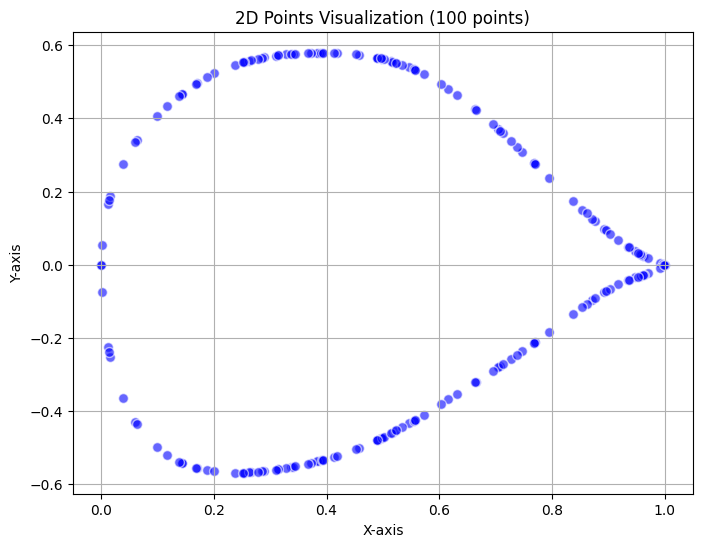

In [114]:
points = loaded_pointcloud[16]
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], 
            c='blue', alpha=0.6, 
            edgecolors='w', s=50)

plt.title("2D Points Visualization (100 points)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()

In [115]:
from math import sqrt
def cal_alpha_bar(alpha, max_t):
    '''
    alpha : torch[max_t]
    sqrtalphabar, sqrt_1_m_alphabar : torch[max_t]
    '''
    sqrtalphabar=torch.empty(max_t)
    sqrt_1_m_alphabar=torch.empty(max_t)
    alphabar_temp=1
    for i in range(max_t):
        alphabar_temp=alphabar_temp*alpha[i]
        sqrtalphabar[i]=sqrt(alphabar_temp)
        sqrt_1_m_alphabar[i]=sqrt(1-alphabar_temp)
    return sqrtalphabar, sqrt_1_m_alphabar
global sqrtalphabar,sqrt_1_m_alphabar
alpha=1-torch.linspace(0.0001, 0.02, steps=500)
sqrtalphabar,sqrt_1_m_alphabar = cal_alpha_bar(alpha, 500)

In [116]:
def random_sample_points(input, num_samples=100):
    B, D, N = input.shape
    # 生成随机索引（每个样本独立采样，不重复）
    indices = torch.stack([torch.randperm(N)[:num_samples] for _ in range(B)], dim=0)  # [B, 100]
    indices = indices.unsqueeze(1).expand(-1, D, -1)  # [B, D, 100]
    # 使用 gather 采样
    sampled = torch.gather(input, dim=2, index=indices.to(input.device))
    return sampled

def uniform_sample_t(num_steps,batch_size):
    ts = np.random.choice(np.arange(1, num_steps), batch_size)
    ts_tensor = torch.tensor(ts)
    return ts_tensor

In [129]:
input = torch.tensor(points).unsqueeze(0)
with torch.no_grad():
    batch_size, _, point_dim = input.size()
    # time_embedding = uniform_sample_t(500, batch_size)
    time_embedding = [0]
    input = random_sample_points(input, num_samples=100)#[B, D, N sample]

    c0 = sqrtalphabar[time_embedding].view(-1, 1, 1)        # (B, 1, 1)
    c1 = sqrt_1_m_alphabar[time_embedding].view(-1, 1, 1) 

    e_rand = torch.randn_like(input)  # (B, N, d)
    noise_input = c0 * input + c1 * e_rand

    noise_input = noise_input

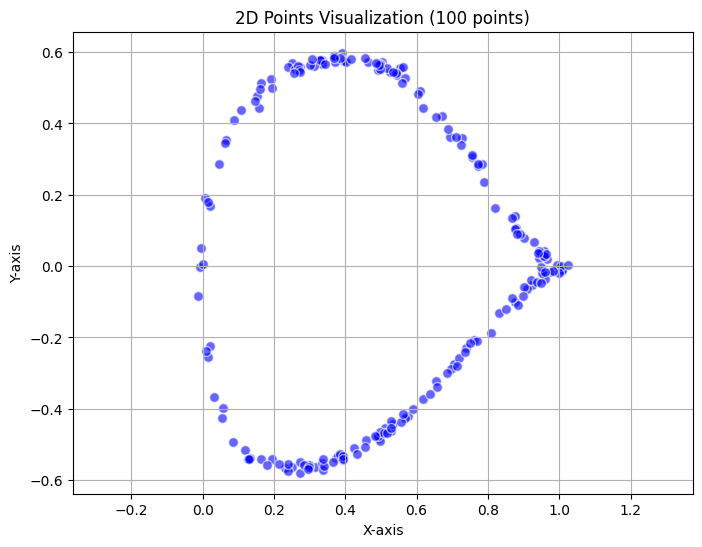

In [130]:
pltpoints = noise_input[0]
plt.figure(figsize=(8, 6))
plt.scatter(pltpoints[:, 0], pltpoints[:, 1], 
            c='blue', alpha=0.6, 
            edgecolors='w', s=50)

plt.title("2D Points Visualization (100 points)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis('equal')
plt.grid(True)
plt.show()

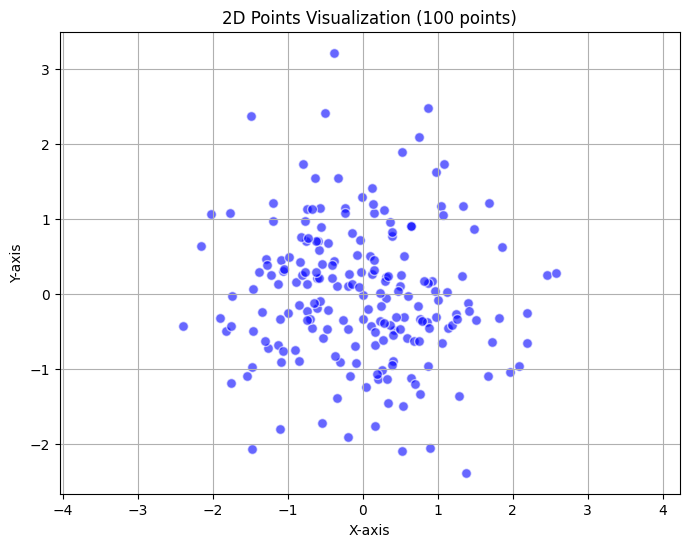

In [131]:
pltpoints = e_rand[0]
plt.figure(figsize=(8, 6))
plt.scatter(pltpoints[:, 0], pltpoints[:, 1], 
            c='blue', alpha=0.6, 
            edgecolors='w', s=50)

plt.title("2D Points Visualization (100 points)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis('equal')
plt.grid(True)
plt.show()